In [230]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('uber_fares.csv')
df['date'] = pd.to_datetime(df['date']).dt.floor('s')

In [231]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [232]:
#df['date'] = df['date'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
# se decide no convertir a hora local porque no es necesario para la mejora del modelo

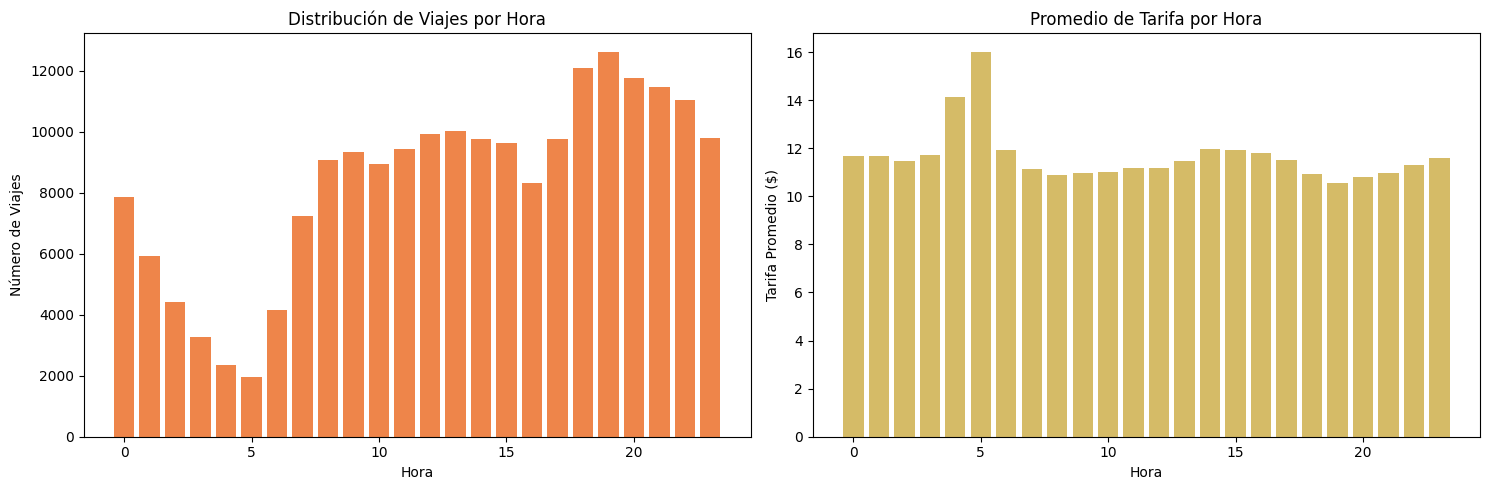

Estadísticas por hora:
    hour  frequency  avg_fare
0      0       7844     11.66
1      1       5908     11.66
2      2       4422     11.45
3      3       3256     11.73
4      4       2365     14.13
5      5       1967     16.00
6      6       4139     11.92
7      7       7231     11.12
8      8       9075     10.90
9      9       9339     10.95
10    10       8944     11.03
11    11       9422     11.19
12    12       9924     11.17
13    13      10024     11.48
14    14       9749     11.98
15    15       9614     11.94
16    16       8313     11.79
17    17       9758     11.49
18    18      12072     10.92
19    19      12605     10.56
20    20      11755     10.80
21    21      11446     10.96
22    22      11023     11.31
23    23       9805     11.58


In [233]:
# 1. Frecuencia y promedio de fare_amount por hora
df['hour'] = df['date'].dt.hour
hourly_stats = df.groupby('hour').agg({
    'fare_amount': ['count', 'mean']
}).round(2)

# Aplanar las columnas
hourly_stats.columns = ['frequency', 'avg_fare']
hourly_stats = hourly_stats.reset_index()

# Crear subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Distribución de viajes por hora (mismo que el 1, pero con otro título)
ax1.bar(hourly_stats['hour'], hourly_stats['frequency'], color=sns.color_palette("muted")[1])
ax1.set_title('Distribución de Viajes por Hora')
ax1.set_xlabel('Hora')
ax1.set_ylabel('Número de Viajes')

# Gráfico 2: Promedio de fare_amount por hora
ax2.bar(hourly_stats['hour'], hourly_stats['avg_fare'], color=sns.color_palette("muted")[8])
ax2.set_title('Promedio de Tarifa por Hora')
ax2.set_xlabel('Hora')
ax2.set_ylabel('Tarifa Promedio ($)')


plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("Estadísticas por hora:")
print(hourly_stats)

In [234]:
# 1. VARIABLES TEMPORALES BÁSICAS

# "hour" fue generada en el paso de análisis de las horas anterior
df['day_of_week'] = df['date'].dt.dayofweek  # 0=Lunes, 6=Domingo
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day

# 2. CODIFICACIÓN CÍCLICA (SENO/COSENO)

# Hora (0-23)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Día de la semana (0-6)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Mes (1-12)
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)  # -1 para que enero=0
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# Día del mes (1-31, aproximado)
df['day_of_month_sin'] = np.sin(2 * np.pi * (df['day_of_month'] - 1) / 31)
df['day_of_month_cos'] = np.cos(2 * np.pi * (df['day_of_month'] - 1) / 31)

# 3. VARIABLES CATEGÓRICAS DE CONTEXTO (dummies de partes relevantes de la semana)

# Jueves, Viernes y Sábado que tienen distribución similar y mayor demanda
df['is_thursday-friday-saturday'] = df['day_of_week'].isin([3, 4, 5]).astype(int)  # Jue=3, Vie=4, Sáb=5,

# Días laborales (Lun, Mar, Mié) que tienen distribución similar y menor demanda
df['is_monday-tuesday-wednesday'] = df['day_of_week'].isin([0, 1, 2]).astype(int)
# Domingo tiene una distribución intermedia, ligeramente distinta al resto de días, no se incluye

# 4. ANÁLISIS DE DEMANDA POR HORA (FRECUENCIA DE VIAJES)

# Contar viajes por hora para identificar patrones de demanda
hourly_trip_counts = df.groupby('hour').size().reset_index(name='trips_per_hour')
print("\nViajes por hora:")
print(hourly_trip_counts.sort_values('trips_per_hour', ascending=False))

# Hacer merge para agregar la información al dataframe
df = df.merge(hourly_trip_counts, on='hour', how='left')

# Crear niveles de demanda basados en terciles de cantidad de viajes
q33 = hourly_trip_counts['trips_per_hour'].quantile(0.33)
q66 = hourly_trip_counts['trips_per_hour'].quantile(0.66)

def classify_demand(trips):
    if trips <= q33:
        return 'low'
    elif trips <= q66:
        return 'medium'
    else:
        return 'high'

df['demand_level'] = df['trips_per_hour'].apply(classify_demand)

# One-hot encoding para demand_level
demand_dummies = pd.get_dummies(df['demand_level'], prefix='demand')
df = pd.concat([df, demand_dummies], axis=1)


Viajes por hora:
    hour  trips_per_hour
19    19           12605
18    18           12072
20    20           11755
21    21           11446
22    22           11023
13    13           10024
12    12            9924
23    23            9805
17    17            9758
14    14            9749
15    15            9614
11    11            9422
9      9            9339
8      8            9075
10    10            8944
16    16            8313
0      0            7844
7      7            7231
1      1            5908
2      2            4422
6      6            4139
3      3            3256
4      4            2365
5      5            1967


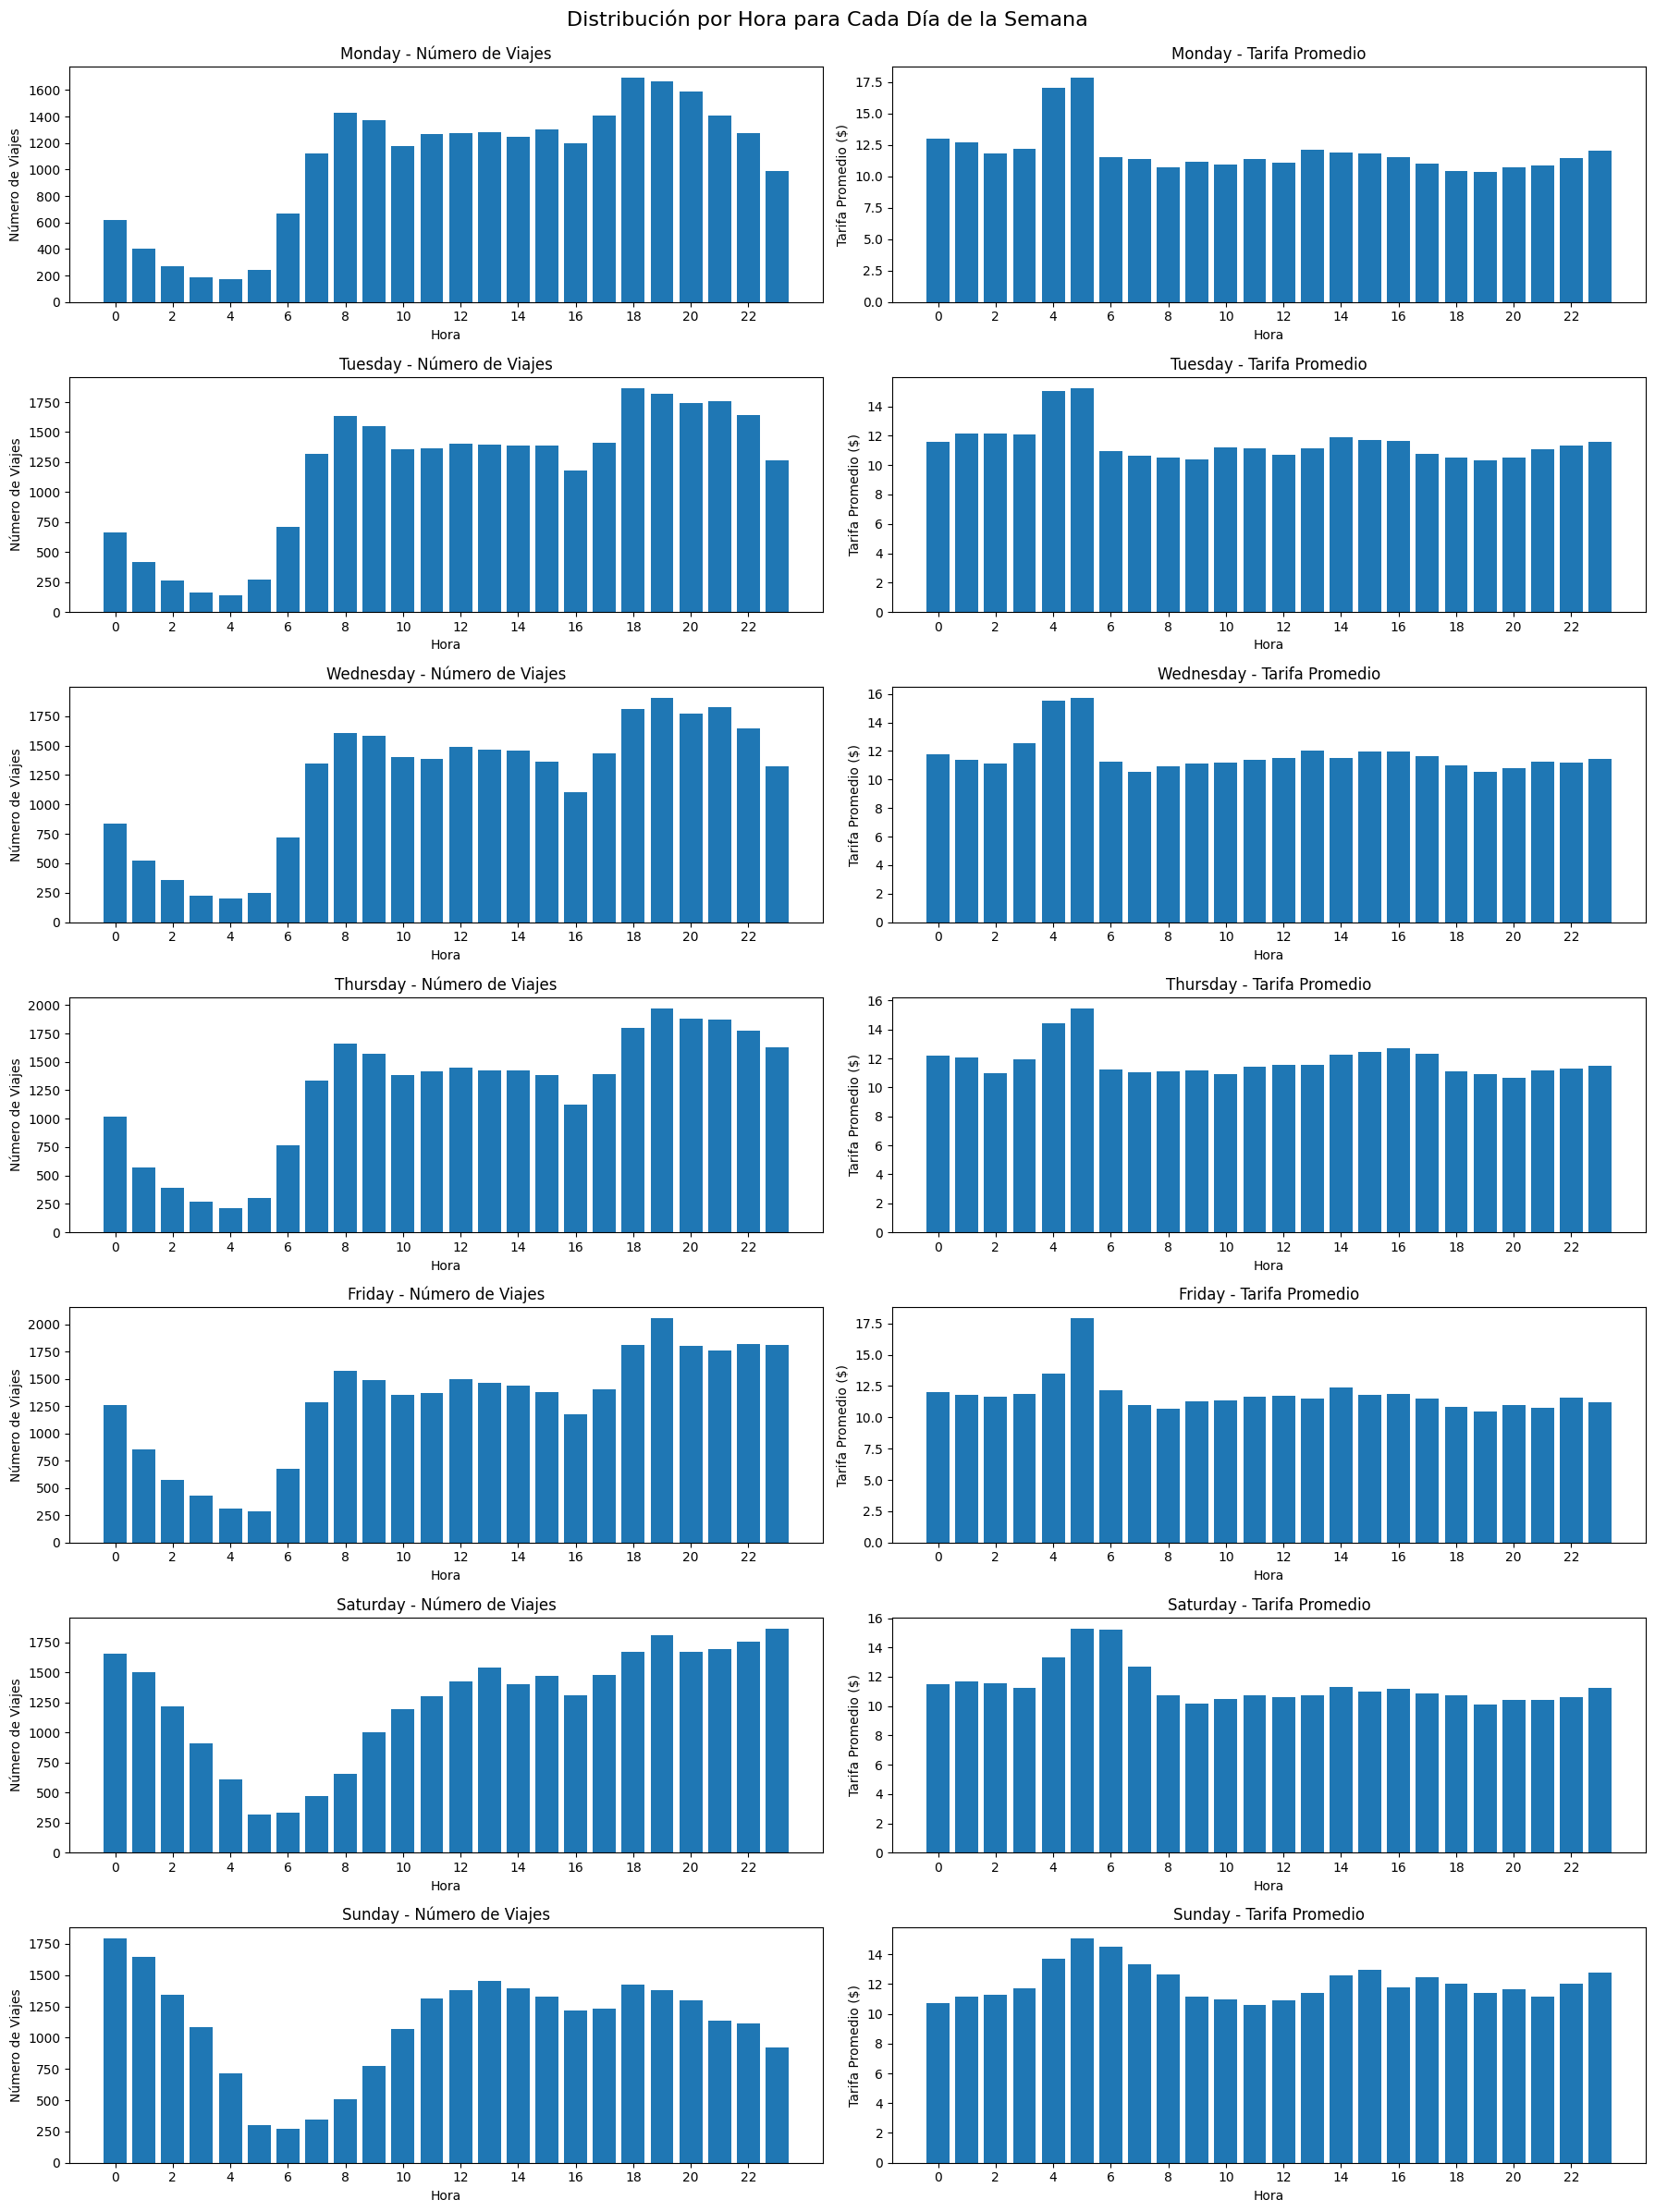

Resumen por día de la semana:
              total_trips  avg_fare
weekday_name                       
Monday              25243     11.38
Tuesday             28127     11.08
Wednesday           29037     11.35
Thursday            30021     11.52
Friday              30880     11.44
Saturday            30251     11.03
Sunday              26441     11.76

Horas con mayor demanda por día:
Monday: Hora 18 con 1690 viajes
Tuesday: Hora 18 con 1866 viajes
Wednesday: Hora 19 con 1901 viajes
Thursday: Hora 19 con 1970 viajes
Friday: Hora 19 con 2054 viajes
Saturday: Hora 23 con 1863 viajes
Sunday: Hora 0 con 1791 viajes


In [235]:
# Extraer hora y día de la semana
df['weekday_name'] = df['date'].dt.day_name()

# Estadísticas por hora y día de la semana
hourly_weekday_stats = df.groupby(['day_of_week', 'weekday_name', 'hour']).agg({
    'fare_amount': ['count', 'mean']
}).round(2)

# Aplanar las columnas
hourly_weekday_stats.columns = ['frequency', 'avg_fare']
hourly_weekday_stats = hourly_weekday_stats.reset_index()

# Crear nombres de días en orden
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Crear figura con subplots para cada día
fig, axes = plt.subplots(7, 2, figsize=(18, 24))
fig.suptitle('Distribución por Hora para Cada Día de la Semana', fontsize=16, y=0.995)

for i, day_name in enumerate(day_names):
    day_data = hourly_weekday_stats[hourly_weekday_stats['weekday_name'] == day_name]
    
    # Gráfico de frecuencia (columna izquierda)
    axes[i, 0].bar(day_data['hour'], day_data['frequency'])
    axes[i, 0].set_title(f'{day_name} - Número de Viajes')
    axes[i, 0].set_xlabel('Hora')
    axes[i, 0].set_ylabel('Número de Viajes')
    axes[i, 0].set_xticks(range(0, 24, 2))
    
    # Gráfico de tarifa promedio (columna derecha)
    axes[i, 1].bar(day_data['hour'], day_data['avg_fare'])
    axes[i, 1].set_title(f'{day_name} - Tarifa Promedio')
    axes[i, 1].set_xlabel('Hora')
    axes[i, 1].set_ylabel('Tarifa Promedio ($)')
    axes[i, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

# Mostrar estadísticas resumidas por día de la semana
print("Resumen por día de la semana:")
weekday_summary = df.groupby('weekday_name').agg({
    'fare_amount': ['count', 'mean']
}).round(2)
weekday_summary.columns = ['total_trips', 'avg_fare']
weekday_summary = weekday_summary.reindex(day_names)
print(weekday_summary)

print("\nHoras con mayor demanda por día:")
for day_name in day_names:
    day_data = hourly_weekday_stats[hourly_weekday_stats['weekday_name'] == day_name]
    peak_hour = day_data.loc[day_data['frequency'].idxmax(), 'hour']
    peak_count = day_data['frequency'].max()
    print(f"{day_name}: Hora {peak_hour} con {peak_count} viajes")

De los gráficos de frecuencia de viajes por hora del día observamos:
Gran demanda entre las 18 y las 22.
Demanda mínima entre las 3 y 4 am.


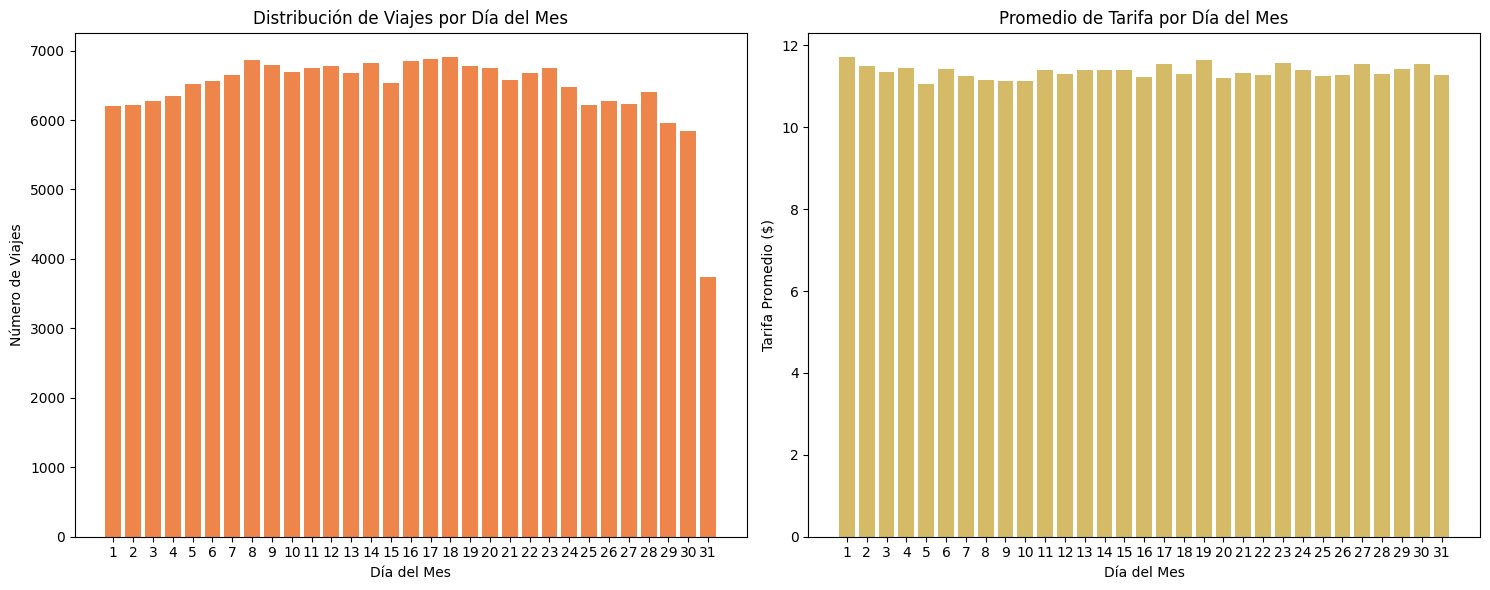

Estadísticas por día del mes:
    day_of_month  frequency  avg_fare
0              1       6203     11.72
1              2       6220     11.49
2              3       6281     11.35
3              4       6340     11.45
4              5       6517     11.06
5              6       6566     11.42
6              7       6643     11.24
7              8       6869     11.15
8              9       6790     11.14
9             10       6689     11.12
10            11       6749     11.40
11            12       6773     11.31
12            13       6681     11.41
13            14       6826     11.40
14            15       6526     11.41
15            16       6850     11.22
16            17       6876     11.55
17            18       6910     11.31
18            19       6774     11.64
19            20       6747     11.21
20            21       6579     11.33
21            22       6683     11.28
22            23       6752     11.58
23            24       6481     11.39
24            25    

In [236]:
# Estadísticas por día del mes
daily_stats = df.groupby('day_of_month').agg({
    'fare_amount': ['count', 'mean']
}).round(2)

# Aplanar las columnas
daily_stats.columns = ['frequency', 'avg_fare']
daily_stats = daily_stats.reset_index()

# Crear subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Frecuencia de viajes por día del mes
ax1.bar(daily_stats['day_of_month'], daily_stats['frequency'], color=sns.color_palette("muted")[1])
ax1.set_title('Distribución de Viajes por Día del Mes')
ax1.set_xlabel('Día del Mes')
ax1.set_ylabel('Número de Viajes')
ax1.set_xticks(range(1, 32))

# Gráfico 2: Promedio de tarifa por día del mes
ax2.bar(daily_stats['day_of_month'], daily_stats['avg_fare'], color=sns.color_palette("muted")[8])
ax2.set_title('Promedio de Tarifa por Día del Mes')
ax2.set_xlabel('Día del Mes')
ax2.set_ylabel('Tarifa Promedio ($)')
ax2.set_xticks(range(1, 32))

plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("Estadísticas por día del mes:")
print(daily_stats)

Decidimos no generar dummies relacionadas con los días del mes por varias razones:
- Variación mínima: Las tarifas van de ~11.5 a ~12.0, una diferencia de solo $0.50.
- Principio de parsimonia: Un buen modelo usa solo variables que realmente aportan. Agregar dummies que no explican aumenta la complejidad sin beneficio.
- Riesgo de overfitting: Más variables = más posibilidad de capturar ruido random en lugar de patrones relevantes.

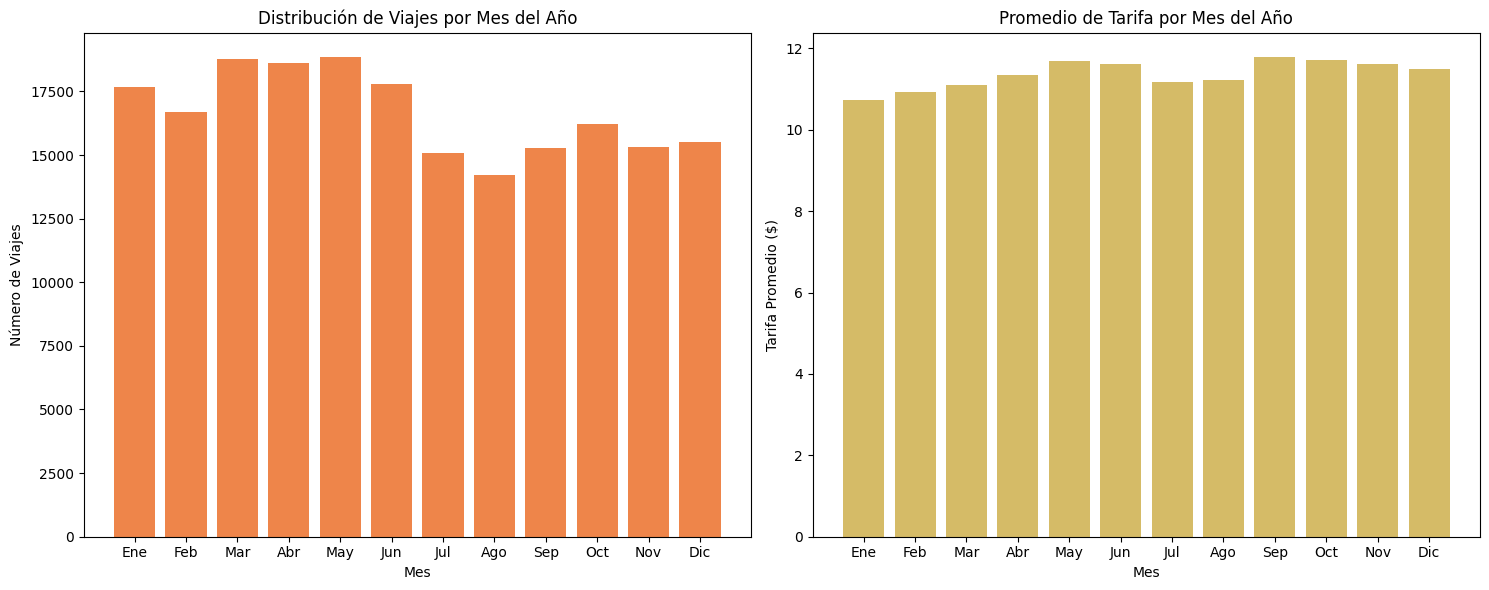

Estadísticas por mes:
    month  frequency  avg_fare
0       1      17668     10.73
1       2      16695     10.93
2       3      18763     11.10
3       4      18606     11.34
4       5      18859     11.68
5       6      17787     11.61
6       7      15095     11.16
7       8      14221     11.21
8       9      15266     11.79
9      10      16212     11.72
10     11      15312     11.61
11     12      15516     11.50


In [237]:
# Estadísticas por mes
monthly_stats = df.groupby('month').agg({
    'fare_amount': ['count', 'mean']
}).round(2)

# Aplanar las columnas
monthly_stats.columns = ['frequency', 'avg_fare']
monthly_stats = monthly_stats.reset_index()

# Crear subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Frecuencia de viajes por mes
ax1.bar(monthly_stats['month'], monthly_stats['frequency'], color=sns.color_palette("muted")[1])
ax1.set_title('Distribución de Viajes por Mes del Año')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Número de Viajes')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

# Gráfico 2: Promedio de tarifa por mes
ax2.bar(monthly_stats['month'], monthly_stats['avg_fare'], color=sns.color_palette("muted")[8])
ax2.set_title('Promedio de Tarifa por Mes del Año')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Tarifa Promedio ($)')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("Estadísticas por mes:")
print(monthly_stats)

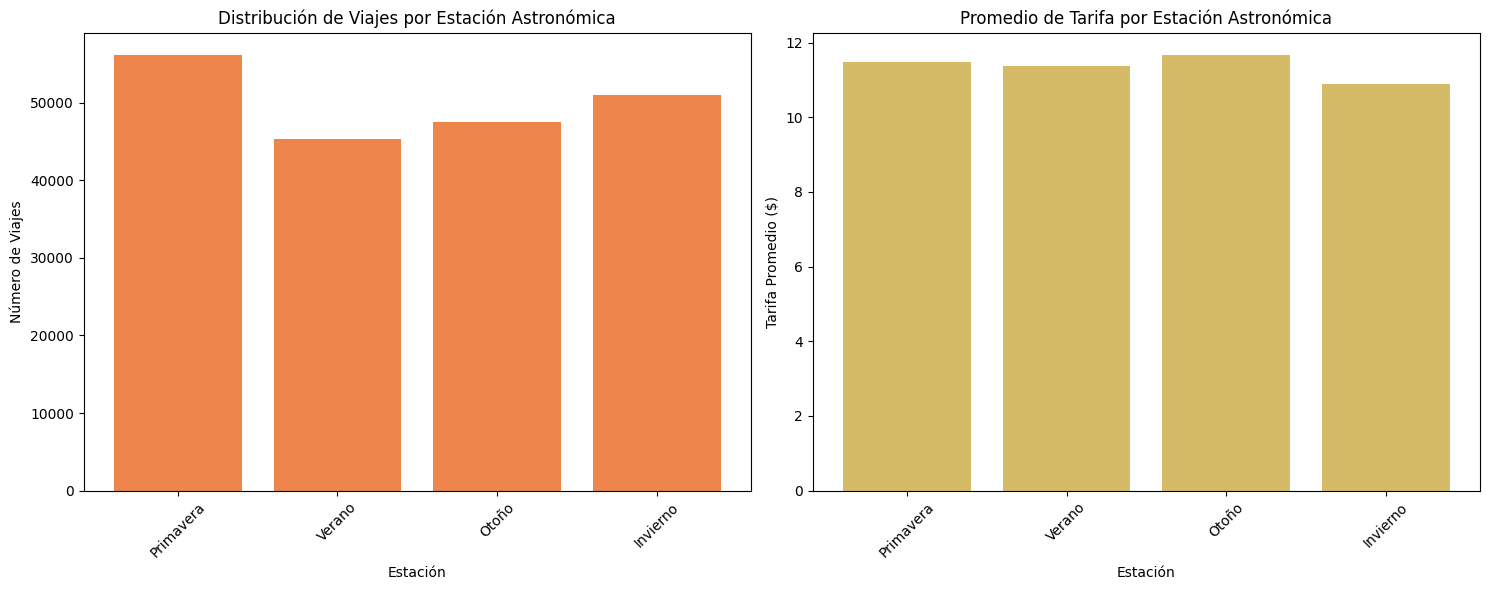

Estadísticas por estación astronómica:
      season  frequency  avg_fare
0  Primavera      56211     11.49
1     Verano      45342     11.37
2      Otoño      47491     11.68
3   Invierno      50956     10.90


In [238]:
# Función para asignar estación astronómica
def get_astronomical_season(month, day):
    # Primavera: 21 marzo - 20 junio
    if (month == 3 and day >= 21) or (month in [4, 5]) or (month == 6 and day <= 20):
        return 'Primavera'
    # Verano: 21 junio - 20 septiembre  
    elif (month == 6 and day >= 21) or (month in [7, 8]) or (month == 9 and day <= 20):
        return 'Verano'
    # Otoño: 21 septiembre - 20 diciembre
    elif (month == 9 and day >= 21) or (month in [10, 11]) or (month == 12 and day <= 20):
        return 'Otoño'
    # Invierno: 21 diciembre - 20 marzo
    else:  # (month == 12 and day >= 21) or (month in [1, 2]) or (month == 3 and day <= 20)
        return 'Invierno'

# Aplicar la función
df['season'] = df.apply(lambda x: get_astronomical_season(x['month'], x['day_of_month']), axis=1)

# Estadísticas por estación
season_stats = df.groupby('season').agg({
    'fare_amount': ['count', 'mean']
}).round(2)

# Aplanar las columnas
season_stats.columns = ['frequency', 'avg_fare']
season_stats = season_stats.reset_index()

# Ordenar por orden lógico de estaciones
season_order = ['Primavera', 'Verano', 'Otoño', 'Invierno']
season_stats['season'] = pd.Categorical(season_stats['season'], categories=season_order, ordered=True)
season_stats = season_stats.sort_values('season').reset_index(drop=True)

# Crear subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Frecuencia de viajes por estación
ax1.bar(season_stats['season'], season_stats['frequency'], color=sns.color_palette("muted")[1])
ax1.set_title('Distribución de Viajes por Estación Astronómica')
ax1.set_xlabel('Estación')
ax1.set_ylabel('Número de Viajes')
ax1.tick_params(axis='x', rotation=45)

# Gráfico 2: Promedio de tarifa por estación
ax2.bar(season_stats['season'], season_stats['avg_fare'], color=sns.color_palette("muted")[8])
ax2.set_title('Promedio de Tarifa por Estación Astronómica')
ax2.set_xlabel('Estación')
ax2.set_ylabel('Tarifa Promedio ($)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("Estadísticas por estación astronómica:")
print(season_stats)

# # Crear dummies para regresión
# df['spring'] = (df['season'] == 'Primavera').astype(int)
# df['summer'] = (df['season'] == 'Verano').astype(int)  
# df['fall'] = (df['season'] == 'Otoño').astype(int)
# df['winter'] = (df['season'] == 'Invierno').astype(int)

# print("\nDummies creados:")
# print("spring, summer, fall, winter")
# print("Distribución de estaciones:")
# print(df['season'].value_counts())

Nuevamente no encontramos diferencias marcadas entre las estaciones, decidimos por el principio de parsimonia no generar nuevas dummies.

In [239]:
# Generación de dummies para hora pico (tarde-noche) y madrugada. Que son horas con demanda significativamente distinta al resto del día.

df['is_dawn'] = df['hour'].isin([4,5]).astype(int)

df['is_peak_hour'] = df['hour'].isin([18,19,20,21,22]).astype(int)

In [240]:
# 5. RESUMEN Y LIMPIEZA

# Eliminar columnas intermedias que no necesitamos para el modelo
columns_to_drop = ['hour', 'day_of_week','trips_per_hour','demand_level', 'demand_low', 'month', 'day_of_month', 'season', 'weekday_name', "day_of_week_cos", "day_of_week_sin", "demand_high", "demand_medium", 'hour_sin', 'hour_cos', 'day_of_month_sin', 'day_of_month_cos']
df = df.drop(columns=columns_to_drop)

# Mostrar todas las nuevas columnas creadas
new_columns = [col for col in df.columns if col not in ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 
               'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare_amount', 'date']]

print(f"\nCOLUMNAS CREADAS")
for col in sorted(new_columns):
    print(f"- {col}")

print(f"\nTotal de nuevas features temporales: {len(new_columns)}")

# 6. VERIFICACIÓN FINAL
print(f"Shape del dataframe: {df.shape}")
print("\nPrimeras filas de las nuevas variables:")
display(df[new_columns].head())


COLUMNAS CREADAS
- is_dawn
- is_monday-tuesday-wednesday
- is_peak_hour
- is_thursday-friday-saturday
- month_cos
- month_sin

Total de nuevas features temporales: 6
Shape del dataframe: (200000, 15)

Primeras filas de las nuevas variables:


,month_sin,month_cos,is_thursday-friday-saturday,is_monday-tuesday-wednesday,is_dawn,is_peak_hour
0,8.660254e-01,-0.500000,1,0,0,1
1,1.224647e-16,-1.000000,1,0,0,1
2,-5.000000e-01,-0.866025,0,1,0,1
3,5.000000e-01,-0.866025,1,0,0,0
4,-5.000000e-01,-0.866025,1,0,0,0


In [241]:
df

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,month_sin,month_cos,is_thursday-friday-saturday,is_monday-tuesday-wednesday,is_dawn,is_peak_hour
0,24238194,2015-05-07 19:52:06,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,8.660254e-01,-5.000000e-01,1,0,0,1
1,27835199,2009-07-17 20:04:56,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,1.224647e-16,-1.000000e+00,1,0,0,1
2,44984355,2009-08-24 21:45:00,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,-5.000000e-01,-8.660254e-01,0,1,0,1
3,25894730,2009-06-26 08:22:21,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,5.000000e-01,-8.660254e-01,1,0,0,0
4,17610152,2014-08-28 17:47:00,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,-5.000000e-01,-8.660254e-01,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,-1.000000e+00,-1.836970e-16,0,0,0,0
199996,16382965,2014-03-14 01:09:00,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,8.660254e-01,5.000000e-01,1,0,0,0
199997,27804658,2009-06-29 00:42:00,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,5.000000e-01,-8.660254e-01,0,1,0,0
199998,20259894,2015-05-20 14:56:25,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,8.660254e-01,-5.000000e-01,0,1,0,0
